In [ ]:
import pandas as pd          # pandam da pandam
import numpy as np           # Sayısal hesaplamalar
import matplotlib.pyplot as plt  # Grafik çizimi
import seaborn as sns        # Gelişmiş görselleştirme
import tensorflow as tf      # Makine öğrenmesi modeli
from sklearn.metrics import r2_score, mean_squared_error  # Model değerlendirme
import os                    # Dosya işlemleri
import glob                  # Dosya arama
import warnings
import random                # Python random modülü
warnings.filterwarnings('ignore')  # Uyarıları gizle

np.random.seed(42)           # NumPy random seed
tf.random.set_seed(42)       # TensorFlow random seed  
random.seed(42)              # Python random seed
os.environ['PYTHONHASHSEED'] = '42'  # Hash randomization

# Grafik ayarları
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12


In [2]:
# Adım 2: Co verilerini bul ve listele
# Dosya yapısı ve konsantrasyonları kontrol et

co_data_path = "../ICP_OES_Fitting_Data/Co/"
co_files = glob.glob(os.path.join(co_data_path, "Co*.csv"))

print(f"Bulunan dosya sayısı: {len(co_files)}")

if not co_files:
    print("Hiçbir Co veri dosyası bulunamadı. Bir önceki klasör için ../--, aynı dizin için /---")
else:
    # Dosyaları konsantrasyona göre sırala
    def extract_concentration(filename):
        # Dosya isminden konsantrasyonu alır
        try:
            basename = os.path.basename(filename)
            conc_str = basename.split('--')[1].split(' ppm')[0]
            return float(conc_str)
        except (IndexError, ValueError):
            print(f"Dosya ismi parse edilemedi: {basename}")
            return 0.0

    co_files.sort(key=extract_concentration)

    print("\nCo veri dosyaları (konsantrasyona göre sıralı):")
    print("=" * 60)
    for i, file in enumerate(co_files, 1):
        filename = os.path.basename(file)
        try:
            file_size = os.path.getsize(file) / 1024
            conc = extract_concentration(file)
            print(f"{i:2d}. {filename} ({file_size:.1f} KB) - {conc:.1f} ppm")
        except Exception as e:
            print(f"{i:2d}. {filename} - Dosya bilgisi alınamadı: {e}")

    # Konsantrasyonları dosya isimlerinden çıkar
    concentrations = []
    for file in co_files:
        conc = extract_concentration(file)
        if conc > 0:
            concentrations.append(conc)

    if concentrations:
        print(f"\nKonsantrasyonlar (sıralı): {concentrations} ppm")
        print(f"Konsantrasyon aralığı: {min(concentrations)} - {max(concentrations)} ppm")
        print(f"Toplam veri noktası: {len(concentrations)}")

        # Dalga boyu bilgisini çıkar
        try:
            sample_filename = os.path.basename(co_files[0])
            wavelength_info = sample_filename.split('(')[1].split(')')[0]
            wavelength_nm = wavelength_info.replace('n', '.')
            print(f"Analiz dalga boyu: {wavelength_nm} nm")
        except Exception as e:
            print(f"Dalga boyu bilgisi çıkarılamadı: {e}")
    else:
        print("Geçerli konsantrasyon değeri bulunamadı")


Bulunan dosya sayısı: 7

Co veri dosyaları (konsantrasyona göre sıralı):
 1. Co(228n615)--0 ppm.csv (1.2 KB) - 0.0 ppm
 2. Co(228n615)--1 ppm.csv (1.3 KB) - 1.0 ppm
 3. Co(228n615)--5 ppm.csv (1.3 KB) - 5.0 ppm
 4. Co(228n615)--10 ppm.csv (1.3 KB) - 10.0 ppm
 5. Co(228n615)--20 ppm.csv (1.3 KB) - 20.0 ppm
 6. Co(228n615)--50 ppm.csv (1.3 KB) - 50.0 ppm
 7. Co(228n615)--100 ppm.csv (1.4 KB) - 100.0 ppm

Konsantrasyonlar (sıralı): [1.0, 5.0, 10.0, 20.0, 50.0, 100.0] ppm
Konsantrasyon aralığı: 1.0 - 100.0 ppm
Toplam veri noktası: 6
Analiz dalga boyu: 228.615 nm


In [11]:
# Veri okuma fonksiyonu oluşturma
# Bu fonksiyon her CSV dosyasını okur ve temizler

def read_co_data(file_path):

    # İlk satırı atlayarak oku (başlık satırı)
    df = pd.read_csv(file_path, skiprows=1)
    
    # Kolon isimlerini standartlaştır
    df.columns = ['Wavelength', 'Background', 'Spectrum']
    
    # NaN değerleri temizle - sadece Wavelength ve Spectrum'da veri olanları al
    df = df.dropna(subset=['Wavelength', 'Spectrum'])
    
    # Veri tiplerini düzelt
    df['Wavelength'] = pd.to_numeric(df['Wavelength'], errors='coerce')
    df['Spectrum'] = pd.to_numeric(df['Spectrum'], errors='coerce')
    
    return df

# Tüm Co verilerini yükleme
print("Co verileri yükleniyor")
co_data = {}

# Dosya sayısı ve konsantrasyon sayısını kontrol et
print(f"Dosya sayısı: {len(co_files)}")
print(f"Konsantrasyon sayısı: {len(concentrations)}")

# Her dosya için konsantrasyonu dosya isminden çıkar
for i, file in enumerate(co_files):
    # Konsantrasyonu dosya isminden çıkar
    conc = extract_concentration(file)
    
    # Sadece geçerli konsantrasyonları işle
    if conc >= 0:
        try:
            data = read_co_data(file)
            co_data[conc] = data
            print(f"{conc:3.0f} ppm: {len(data)} veri noktası yüklendi")
        except Exception as e:
            print(f"{conc} ppm yüklenemedi: {e}")
    else:
        print(f"Geçersiz konsantrasyon dosyası atlandı: {os.path.basename(file)}")

print(f"\nToplam {len(co_data)} konsantrasyon başarıyla yüklendi")

# Yüklenen konsantrasyonları güncelle
concentrations = sorted(co_data.keys())
print(f"Yüklenen konsantrasyonlar: {concentrations} ppm")

# Örnek veri gösterimi (en düşük konsantrasyon)
if co_data:
    min_conc = min(concentrations)
    print(f"\n{min_conc} ppm verisi örneği (ilk 5 satır):")
    print(co_data[min_conc].head().to_string())
else:
    print("\nHiç veri yüklenemedi")


Co verileri yükleniyor
Dosya sayısı: 7
Konsantrasyon sayısı: 7
  0 ppm: 47 veri noktası yüklendi
  1 ppm: 47 veri noktası yüklendi
  5 ppm: 47 veri noktası yüklendi
 10 ppm: 47 veri noktası yüklendi
 20 ppm: 47 veri noktası yüklendi
 50 ppm: 47 veri noktası yüklendi
100 ppm: 47 veri noktası yüklendi

Toplam 7 konsantrasyon başarıyla yüklendi
Yüklenen konsantrasyonlar: [0.0, 1.0, 5.0, 10.0, 20.0, 50.0, 100.0] ppm

0.0 ppm verisi örneği (ilk 5 satır):
   Wavelength  Background  Spectrum
0     228.585     363.854   359.895
1     228.586     356.074   357.025
2     228.587     349.298   352.456
3     228.589     343.526   346.416
4     228.590     338.710   339.976


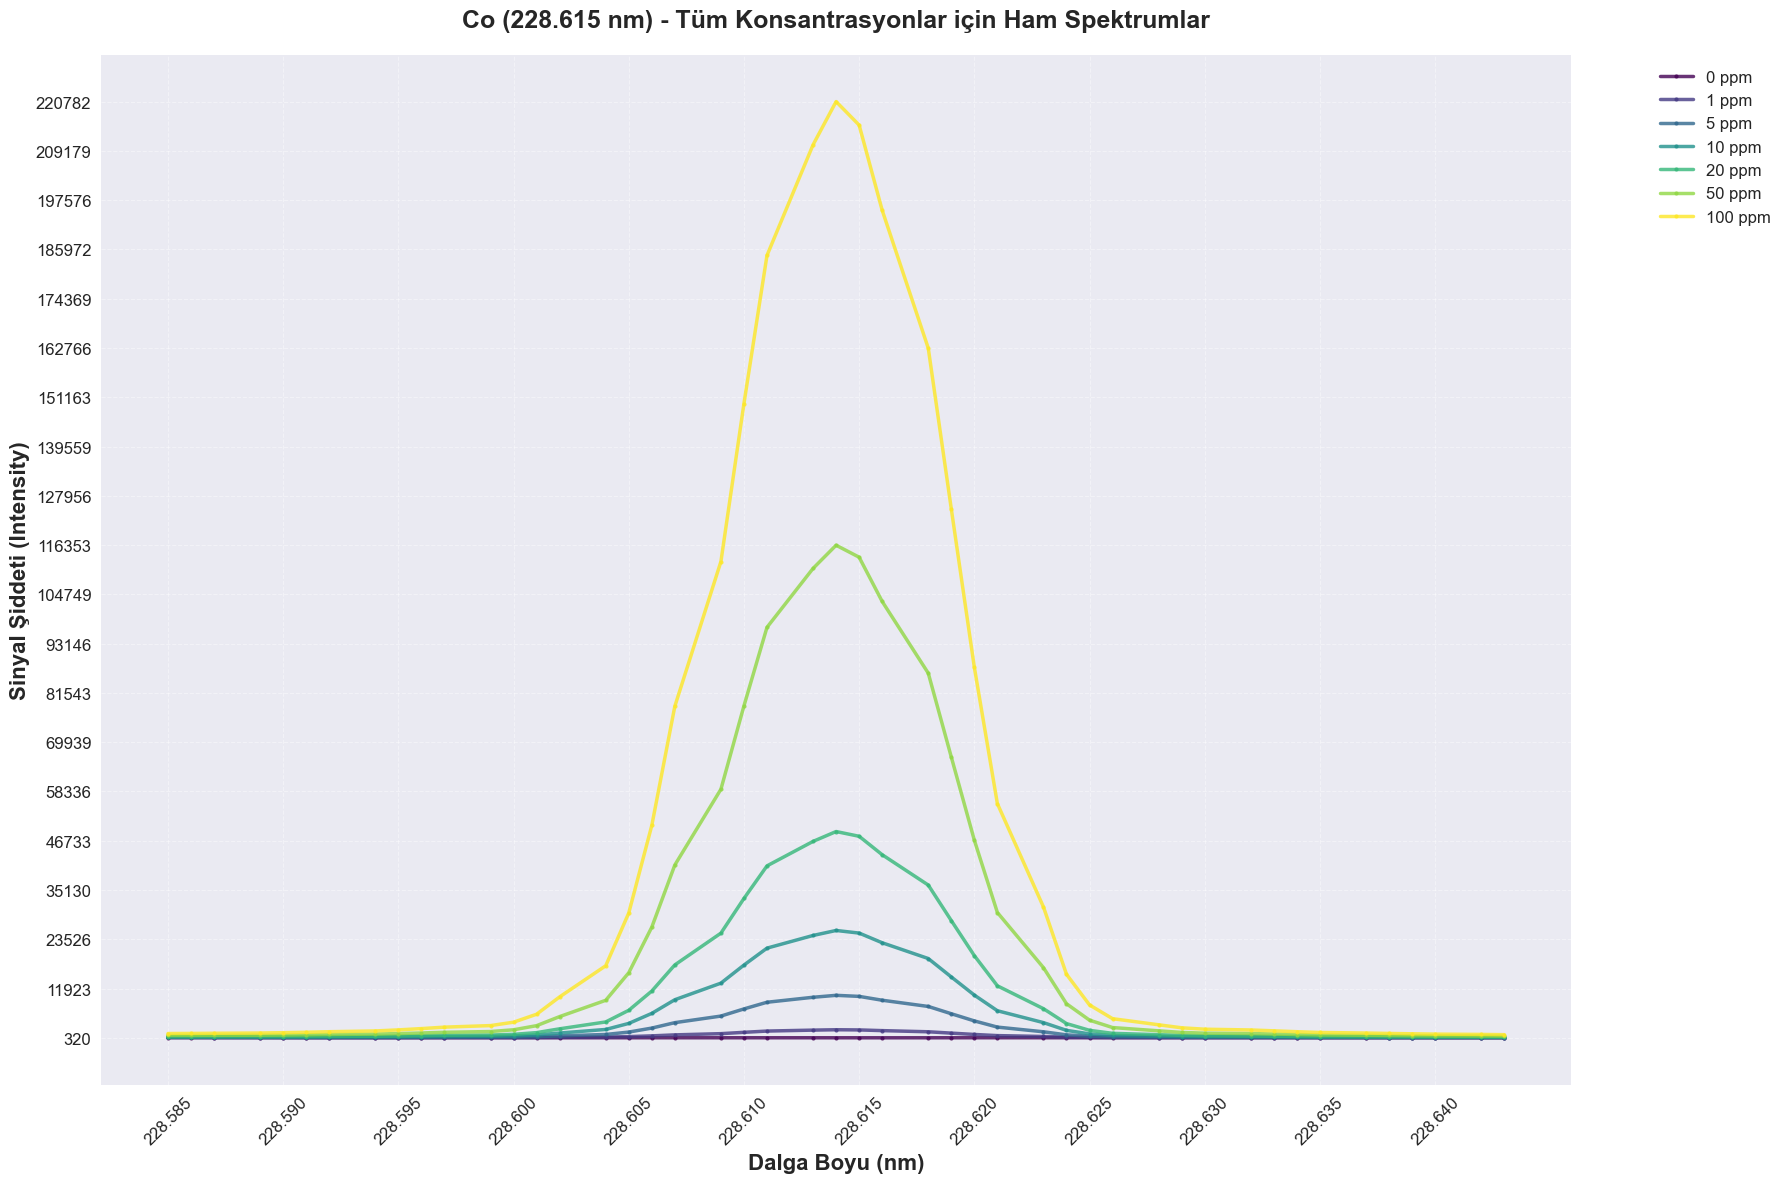

Pik bölgesi analizi (228.610-228.620 nm):
  0 ppm: Max intensity =      329.2 at 228.6200 nm
  1 ppm: Max intensity =     2215.0 at 228.6140 nm
  5 ppm: Max intensity =    10319.4 at 228.6140 nm
 10 ppm: Max intensity =    25592.8 at 228.6140 nm
 20 ppm: Max intensity =    48889.8 at 228.6140 nm
 50 ppm: Max intensity =   116311.0 at 228.6140 nm
100 ppm: Max intensity =   220782.3 at 228.6140 nm


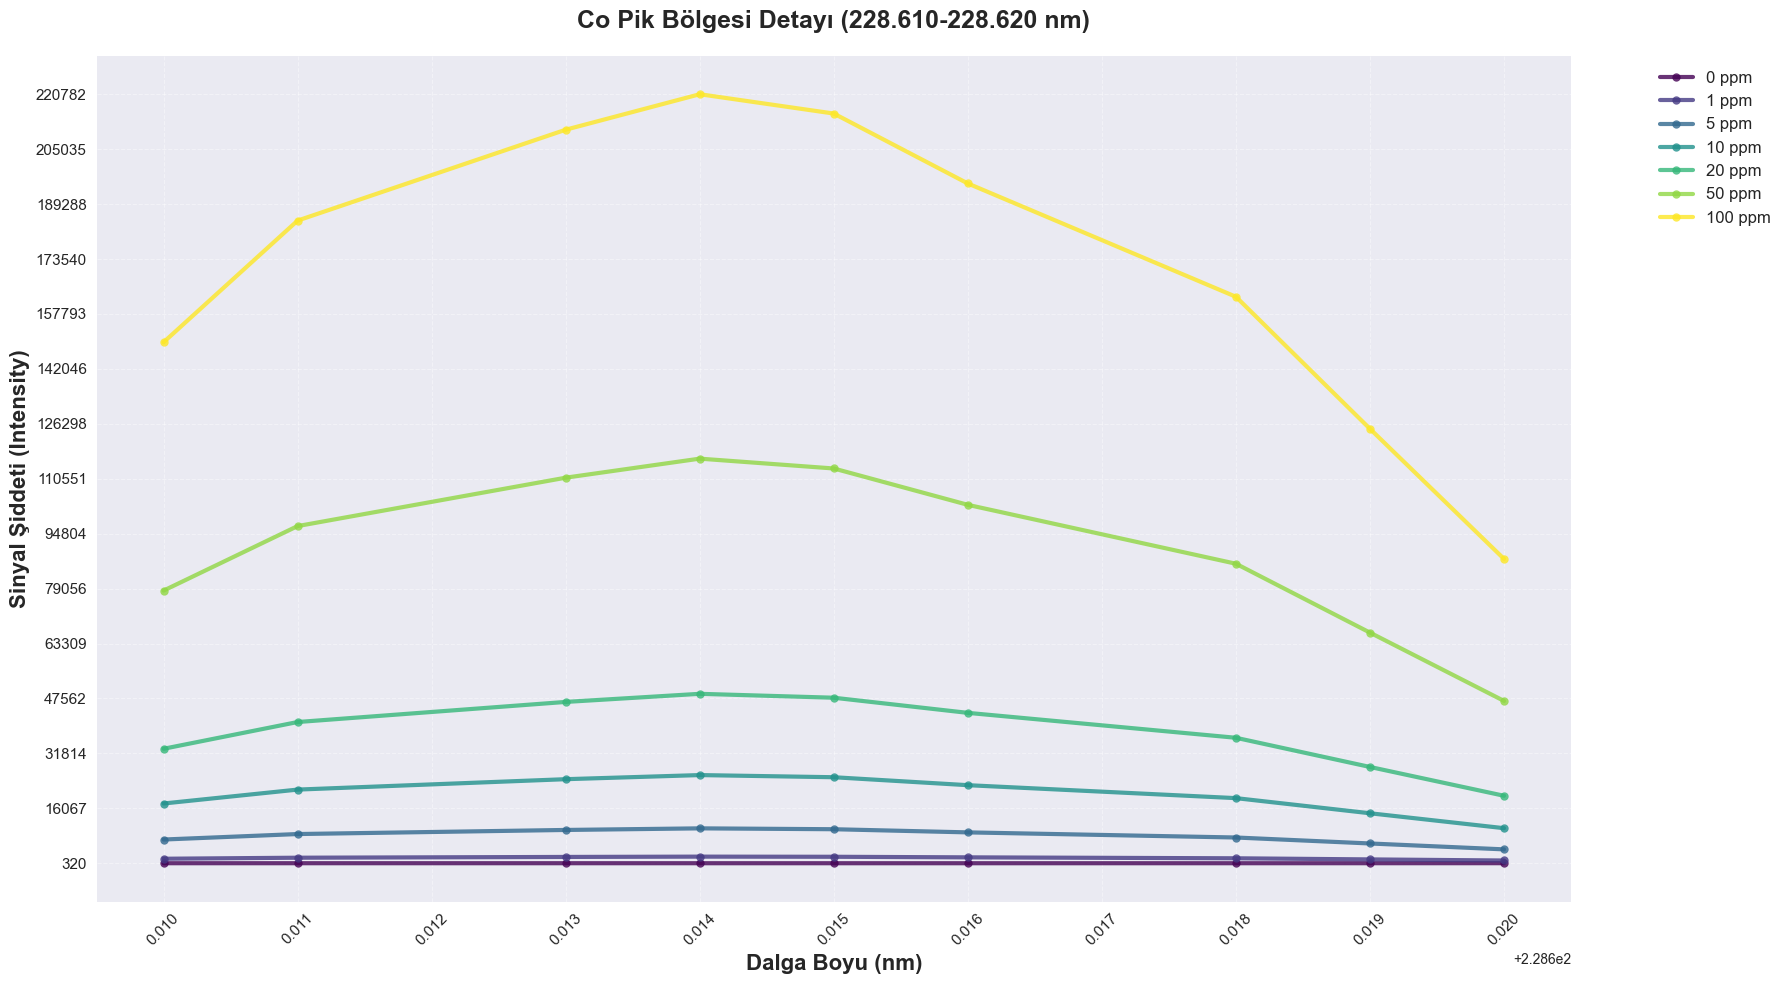


Detaylı Spektrum İstatistikleri:
 Konsantrasyon (ppm) Min Dalga Boyu (nm) Max Dalga Boyu (nm) Dalga Boyu Aralığı (nm) Min Sinyal Max Sinyal Ortalama Sinyal Sinyal Std  Veri Noktası
                 0.0            228.5850            228.6430                  0.0580      319.7      359.9           330.9        8.4            47
                 1.0            228.5850            228.6430                  0.0580      363.3     2215.0           718.6      587.6            47
                 5.0            228.5850            228.6430                  0.0580      366.1    10319.4          2271.5     3161.9            47
                10.0            228.5850            228.6430                  0.0580      424.3    25592.8          5235.0     7995.9            47
                20.0            228.5850            228.6430                  0.0580      490.1    48889.8          9743.0    15379.6            47
                50.0            228.5850            228.6430                  

In [12]:
# Ham spektrumları görselleştirme
# Bu adımda tüm konsantrasyonların spektrumlarını karşılaştırıyoruz

plt.figure(figsize=(18, 12))

# Renk paleti oluşturma - konsantrasyon arttıkça renk değişimi
colors = plt.cm.viridis(np.linspace(0, 1, len(concentrations)))
conc_sorted = sorted(concentrations)

# Her konsantrasyon için spektrum çizme
for i, conc in enumerate(conc_sorted):
    data = co_data[conc]
    plt.plot(data['Wavelength'], data['Spectrum'], 
             label=f'{conc:.0f} ppm', color=colors[i], linewidth=2.5, alpha=0.8, marker='o', markersize=3)

# DETAYLI EKSEN AYARLARI
plt.xlabel('Dalga Boyu (nm)', fontsize=16, fontweight='bold')
plt.ylabel('Sinyal Şiddeti (Intensity)', fontsize=16, fontweight='bold')
plt.title('Co (228.615 nm) - Tüm Konsantrasyonlar için Ham Spektrumlar', fontsize=18, fontweight='bold', pad=20)

# X ekseni detayları - daha fazla tick
wavelength_range = [data['Wavelength'].min() for data in co_data.values()]
min_wavelength = min(wavelength_range)
max_wavelength = max([data['Wavelength'].max() for data in co_data.values()])

# X ekseni: her 0.005 nm'de bir tick
x_ticks = np.arange(np.floor(min_wavelength*1000)/1000, np.ceil(max_wavelength*1000)/1000 + 0.001, 0.005)
plt.xticks(x_ticks, rotation=45, fontsize=12)

# Y ekseni detayları - daha fazla tick
y_max = max([data['Spectrum'].max() for data in co_data.values()])
y_min = min([data['Spectrum'].min() for data in co_data.values()])
y_ticks = np.linspace(y_min, y_max, 20)  # 20 tick
plt.yticks(y_ticks, fontsize=12)

# y ekseni etiketlerinin formatlanması
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0f}'))

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.grid(True, alpha=0.4, linestyle='--', linewidth=0.8)
plt.tight_layout()
plt.show()

# Pik bölgesine odaklanma - 228.610-228.620 nm arası
plt.figure(figsize=(18, 10))

print("Pik bölgesi analizi (228.610-228.620 nm):")
print("=" * 60)

for i, conc in enumerate(conc_sorted):
    data = co_data[conc]
    # Pik bölgesini filtrele
    mask = (data['Wavelength'] >= 228.610) & (data['Wavelength'] <= 228.620)
    filtered_data = data[mask]
    
    if len(filtered_data) > 0:
        max_intensity = filtered_data['Spectrum'].max()
        max_wavelength = filtered_data.loc[filtered_data['Spectrum'].idxmax(), 'Wavelength']
        print(f"{conc:3.0f} ppm: Max intensity = {max_intensity:10.1f} at {max_wavelength:.4f} nm")
        
        plt.plot(filtered_data['Wavelength'], filtered_data['Spectrum'], 
                 label=f'{conc:.0f} ppm', color=colors[i], linewidth=3, 
                 marker='o', markersize=6, alpha=0.8)

# PIK BÖLGESİ DETAYLI EKSEN AYARLARI
plt.xlabel('Dalga Boyu (nm)', fontsize=16, fontweight='bold')
plt.ylabel('Sinyal Şiddeti (Intensity)', fontsize=16, fontweight='bold')
plt.title('Co Pik Bölgesi Detayı (228.610-228.620 nm)', fontsize=18, fontweight='bold', pad=20)

# X ekseni: her 0.001 nm'de bir tick (pik bölgesinde çok detaylı)
x_ticks_peak = np.arange(228.610, 228.621, 0.001)
plt.xticks(x_ticks_peak, rotation=45, fontsize=11)

# Y ekseni: pik bölgesine göre ayarlanmış detaylı tickler
peak_y_values = []
for conc in conc_sorted:
    data = co_data[conc]
    mask = (data['Wavelength'] >= 228.610) & (data['Wavelength'] <= 228.620)
    filtered_data = data[mask]
    if len(filtered_data) > 0:
        peak_y_values.extend(filtered_data['Spectrum'].values)

if peak_y_values:
    y_min_peak = min(peak_y_values)
    y_max_peak = max(peak_y_values)
    y_ticks_peak = np.linspace(y_min_peak, y_max_peak, 15)  # 15 tick
    plt.yticks(y_ticks_peak, fontsize=11)
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0f}'))

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.grid(True, alpha=0.4, linestyle='--', linewidth=0.8)
plt.tight_layout()
plt.show()

# SPEKTRUM İSTATİSTİKLERİ TABLOSU
print("\nDetaylı Spektrum İstatistikleri:")
print("=" * 80)
stats_data = []
for conc in conc_sorted:
    data = co_data[conc]
    stats_data.append({
        'Konsantrasyon (ppm)': conc,
        'Min Dalga Boyu (nm)': f"{data['Wavelength'].min():.4f}",
        'Max Dalga Boyu (nm)': f"{data['Wavelength'].max():.4f}",
        'Dalga Boyu Aralığı (nm)': f"{data['Wavelength'].max() - data['Wavelength'].min():.4f}",
        'Min Sinyal': f"{data['Spectrum'].min():.1f}",
        'Max Sinyal': f"{data['Spectrum'].max():.1f}",
        'Ortalama Sinyal': f"{data['Spectrum'].mean():.1f}",
        'Sinyal Std': f"{data['Spectrum'].std():.1f}",
        'Veri Noktası': len(data)
    })

stats_df = pd.DataFrame(stats_data)
print(stats_df.to_string(index=False))


Background subtraction işlemi başlatılıyor...
Mevcut konsantrasyonlar: [0.0, 1.0, 5.0, 10.0, 20.0, 50.0, 100.0]
Background verisi bulundu: 0.0 ppm
Background verisi: 47 veri noktası
  0 ppm: Background referans (düzeltilmiş spektrum = 0)
  1 ppm: Max düzeltilmiş =   1893.2, Min =     32.1
  5 ppm: Max düzeltilmiş =   9997.5, Min =     34.9
 10 ppm: Max düzeltilmiş =  25270.9, Min =     93.1
 20 ppm: Max düzeltilmiş =  48568.0, Min =    158.9
 50 ppm: Max düzeltilmiş = 115989.2, Min =    382.1
100 ppm: Max düzeltilmiş = 220460.5, Min =    722.6

Background subtraction tamamlandı


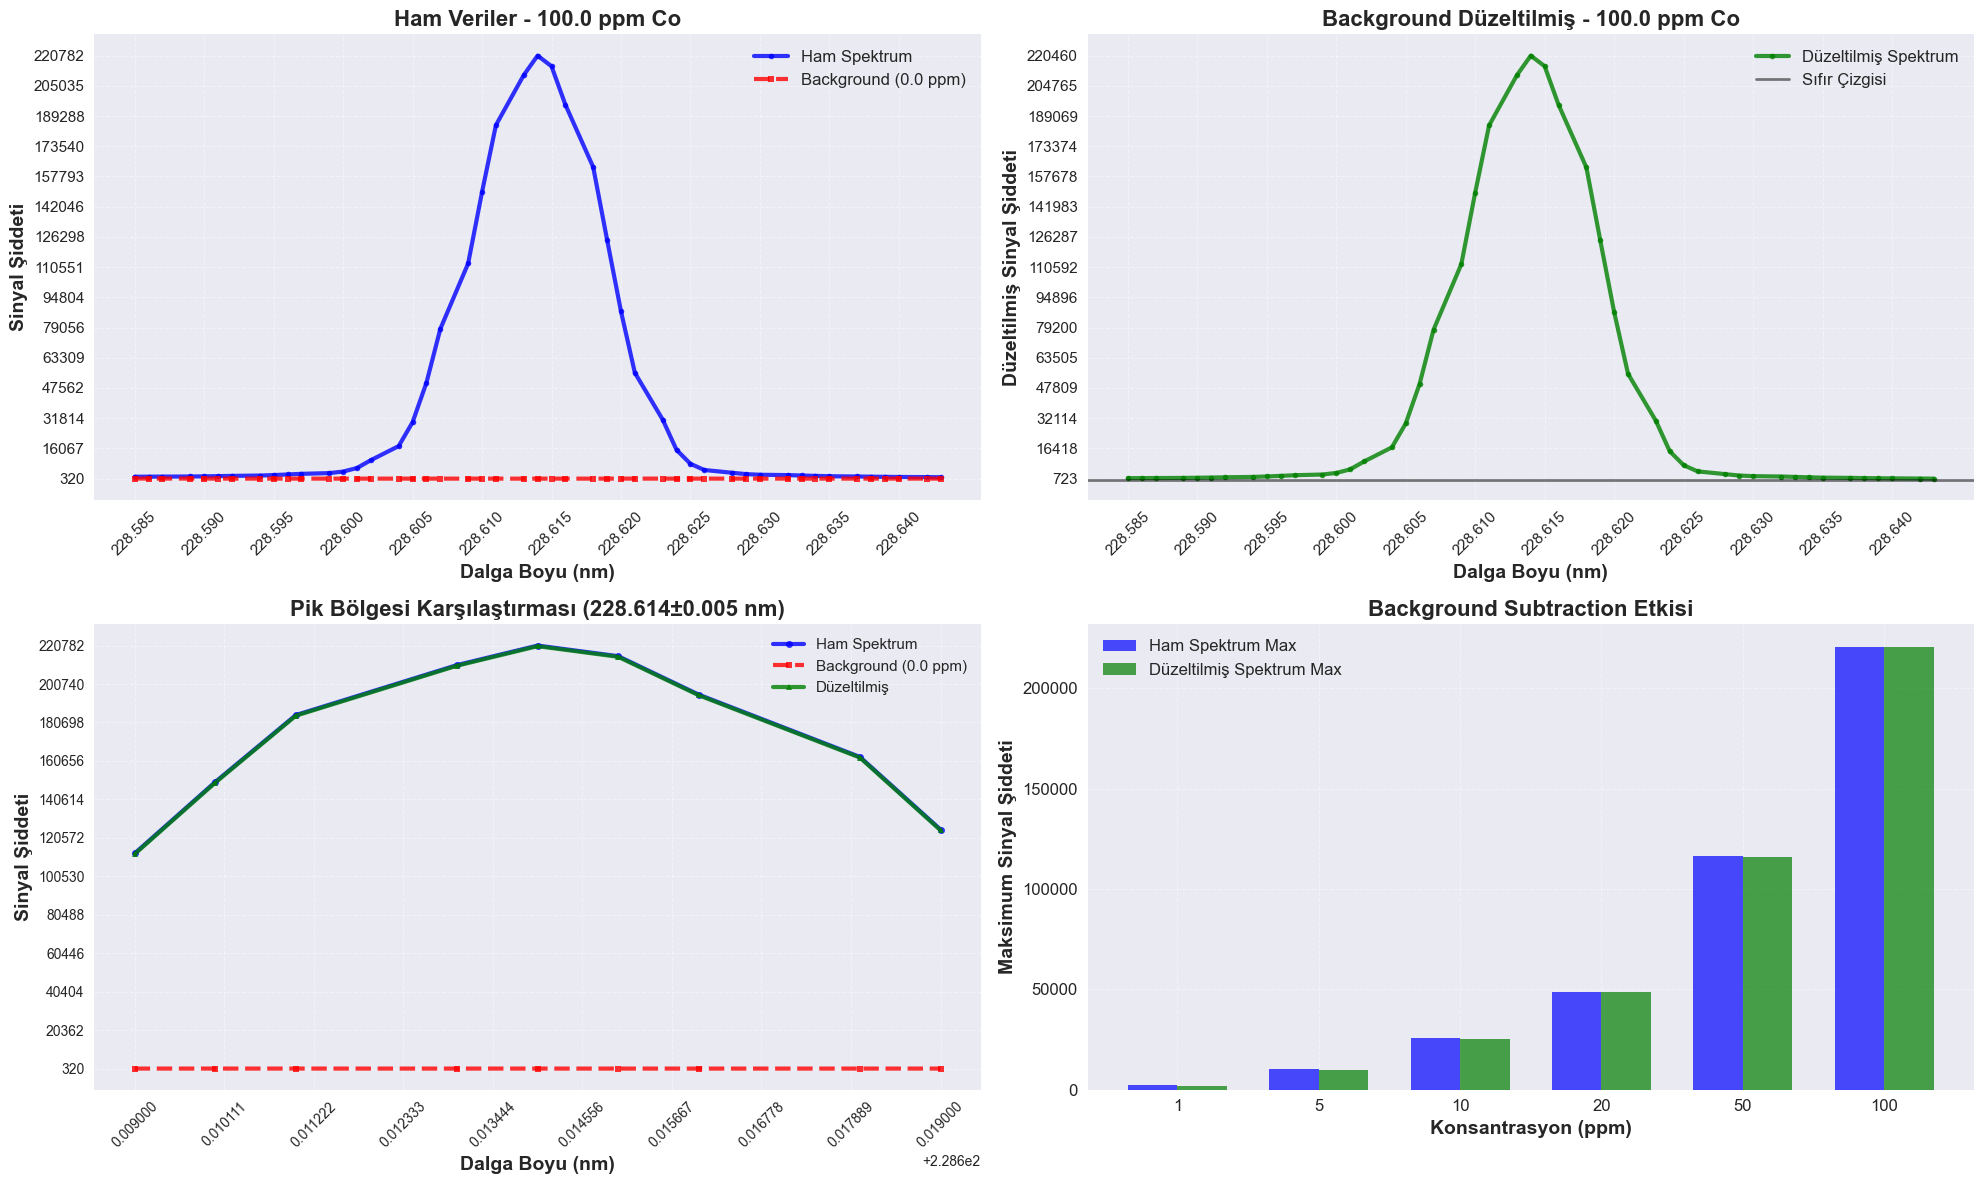


Background Subtraction Detaylı İstatistikleri:
 Konsantrasyon (ppm) Ham Max Sinyal Düzeltilmiş Max Sinyal Background Etkisi Düzeltme Oranı (%) Ham Ortalama Düzeltilmiş Ortalama Sinyal/Gürültü Oranı
                 0.0          359.9                    0.0             359.9                0.0        330.9                  0.0                  N/A
                 1.0         2215.0                 1893.2             321.8               85.5        718.6                387.8                  3.2
                 5.0        10319.4                 9997.5             321.8               96.9       2271.5               1940.7                  3.2
                10.0        25592.8                25270.9             321.8               98.7       5235.0               4904.2                  3.2
                20.0        48889.8                48568.0             321.8               99.3       9743.0               9412.1                  3.2
                50.0       116311.0           

In [ ]:
# Background Subtraction fonksiyonu

def perform_background_subtraction(data, background_data):

    # Aynı dalga boylarında interpolasyon yaparak background çıkarma
    # Bu önemli çünkü dalga boyu değerleri tam olarak eşleşmeyebilir
    bg_interp = np.interp(data['Wavelength'], 
                         background_data['Wavelength'], 
                         background_data['Spectrum'])
    
    # Background-corrected spectrum hesaplama
    corrected_spectrum = data['Spectrum'] - bg_interp
    
    # Yeni DataFrame oluşturma
    corrected_data = data.copy()
    corrected_data['Corrected_Spectrum'] = corrected_spectrum
    corrected_data['Background_Interpolated'] = bg_interp
    
    return corrected_data

# Background olarak 0 ppm verisini kullanma
print("Background subtraction işlemi başlatılıyor...")

# Mevcut konsantrasyonları kontrol et ve 0 ppm'i bul
print(f"Mevcut konsantrasyonlar: {sorted(co_data.keys())}")

# 0 ppm verisi dosya adında zaten var: "Co(228n615)--0 ppm.csv"
background_key = 0

# Neden 0 ppm anahtarı bulunamıyor? Kontrol amaçlı ek bilgi yazdır.
if background_key in co_data:
    background_key = min(co_data.keys())
    print(f"Background verisi bulundu: {background_key} ppm")

background_data = co_data[background_key]
print(f"Background verisi: {len(background_data)} veri noktası")

# Her konsantrasyon için background subtraction
co_data_corrected = {}

for conc in conc_sorted:
    if conc == background_key:
        # Background konsantrasyonu için düzeltilmiş spektrum sıfır olur
        corrected_data = co_data[conc].copy()
        corrected_data['Corrected_Spectrum'] = 0.0
        corrected_data['Background_Interpolated'] = corrected_data['Spectrum']
        co_data_corrected[conc] = corrected_data
        print(f"{conc:3.0f} ppm: Background referans (düzeltilmiş spektrum = 0)")
    else:
        corrected_data = perform_background_subtraction(co_data[conc], background_data)
        co_data_corrected[conc] = corrected_data
        
        # İstatistikler
        max_corrected = corrected_data['Corrected_Spectrum'].max()
        min_corrected = corrected_data['Corrected_Spectrum'].min()
        print(f"{conc:3.0f} ppm: Max düzeltilmiş = {max_corrected:8.1f}, Min = {min_corrected:8.1f}")

print(f"\nBackground subtraction tamamlandı")

# Background subtraction etkisini görselleştirme - DETAYLI VERSİYON
plt.figure(figsize=(20, 12))

# En yüksek konsantrasyon örneği seç
high_conc = max([c for c in conc_sorted if c != background_key])
data_high = co_data[high_conc]
corrected_high = co_data_corrected[high_conc]

# İlk grafik: Ham veriler
plt.subplot(2, 2, 1)
plt.plot(data_high['Wavelength'], data_high['Spectrum'], 'b-', linewidth=3, marker='o', markersize=4, label='Ham Spektrum', alpha=0.8)
plt.plot(background_data['Wavelength'], background_data['Spectrum'], 'r--', linewidth=3, marker='s', markersize=4, label=f'Background ({background_key} ppm)', alpha=0.8)

# Detaylı eksen ayarları
plt.xlabel('Dalga Boyu (nm)', fontsize=14, fontweight='bold')
plt.ylabel('Sinyal Şiddeti', fontsize=14, fontweight='bold')
plt.title(f'Ham Veriler - {high_conc} ppm Co', fontsize=16, fontweight='bold')

# X ekseni detayları
x_min = min(data_high['Wavelength'].min(), background_data['Wavelength'].min())
x_max = max(data_high['Wavelength'].max(), background_data['Wavelength'].max())
x_ticks = np.arange(np.floor(x_min*1000)/1000, np.ceil(x_max*1000)/1000 + 0.001, 0.005)
plt.xticks(x_ticks, rotation=45, fontsize=11)

# Y ekseni detayları
y_min = min(data_high['Spectrum'].min(), background_data['Spectrum'].min())
y_max = max(data_high['Spectrum'].max(), background_data['Spectrum'].max())
y_ticks = np.linspace(y_min, y_max, 15)
plt.yticks(y_ticks, fontsize=11)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0f}'))

plt.legend(fontsize=12)
plt.grid(True, alpha=0.4, linestyle='--', linewidth=0.8)


##


# İkinci grafik: Düzeltilmiş spektrum
plt.subplot(2, 2, 2)
plt.plot(corrected_high['Wavelength'], corrected_high['Corrected_Spectrum'], 'g-', linewidth=3, marker='o', markersize=4, label='Düzeltilmiş Spektrum', alpha=0.8)
plt.axhline(y=0, color='k', linestyle='-', alpha=0.5, linewidth=2, label='Sıfır Çizgisi')

plt.xlabel('Dalga Boyu (nm)', fontsize=14, fontweight='bold')
plt.ylabel('Düzeltilmiş Sinyal Şiddeti', fontsize=14, fontweight='bold')
plt.title(f'Background Düzeltilmiş - {high_conc} ppm Co', fontsize=16, fontweight='bold')

# X ekseni detayları
plt.xticks(x_ticks, rotation=45, fontsize=11)

# Y ekseni detayları - düzeltilmiş spektrum için
y_min_corr = corrected_high['Corrected_Spectrum'].min()
y_max_corr = corrected_high['Corrected_Spectrum'].max()
y_ticks_corr = np.linspace(y_min_corr, y_max_corr, 15)
plt.yticks(y_ticks_corr, fontsize=11)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0f}'))

plt.legend(fontsize=12)
plt.grid(True, alpha=0.4, linestyle='--', linewidth=0.8)

# Üçüncü grafik: Karşılaştırma - Pik bölgesi
plt.subplot(2, 2, 3)

# Pik bölgesini filtrele (Co'nun ana pik dalga boyu etrafında)
# Eğer 228.6 nm civarında pik yoksa, maksimum sinyal bölgesini kullan
peak_wavelength = data_high['Wavelength'][data_high['Spectrum'].idxmax()]
peak_range = 0.005  # ±5 nm aralık

mask = (data_high['Wavelength'] >= peak_wavelength - peak_range) & (data_high['Wavelength'] <= peak_wavelength + peak_range)
peak_data = data_high[mask]
peak_bg = background_data[(background_data['Wavelength'] >= peak_wavelength - peak_range) & (background_data['Wavelength'] <= peak_wavelength + peak_range)]
peak_corr = corrected_high[mask]

if len(peak_data) > 0:
    plt.plot(peak_data['Wavelength'], peak_data['Spectrum'], 'b-', linewidth=3, marker='o', markersize=5, label='Ham Spektrum', alpha=0.8)
    if len(peak_bg) > 0:
        plt.plot(peak_bg['Wavelength'], peak_bg['Spectrum'], 'r--', linewidth=3, marker='s', markersize=5, label=f'Background ({background_key} ppm)', alpha=0.8)
    plt.plot(peak_corr['Wavelength'], peak_corr['Corrected_Spectrum'], 'g-', linewidth=3, marker='^', markersize=5, label='Düzeltilmiş', alpha=0.8)

    plt.xlabel('Dalga Boyu (nm)', fontsize=14, fontweight='bold')
    plt.ylabel('Sinyal Şiddeti', fontsize=14, fontweight='bold')
    plt.title(f'Pik Bölgesi Karşılaştırması ({peak_wavelength:.3f}±{peak_range:.3f} nm)', fontsize=16, fontweight='bold')

    # X ekseni: detaylı
    x_ticks_peak = np.linspace(peak_wavelength - peak_range, peak_wavelength + peak_range, 10)
    plt.xticks(x_ticks_peak, rotation=45, fontsize=10)

    # Y ekseni: pik bölgesine göre
    all_peak_values = list(peak_data['Spectrum']) + list(peak_corr['Corrected_Spectrum'])
    if len(peak_bg) > 0:
        all_peak_values.extend(list(peak_bg['Spectrum']))
    
    if all_peak_values:
        y_min_peak = min(all_peak_values)
        y_max_peak = max(all_peak_values)
        y_ticks_peak = np.linspace(y_min_peak, y_max_peak, 12)
        plt.yticks(y_ticks_peak, fontsize=10)
        plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0f}'))

    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.4, linestyle='--', linewidth=0.8)
else:
    plt.text(0.5, 0.5, 'Pik bölgesi verisi bulunamadı', ha='center', va='center', transform=plt.gca().transAxes, fontsize=14)


##


# Dördüncü grafik: Background subtraction istatistikleri
plt.subplot(2, 2, 4)
conc_list = []
max_raw = []
max_corrected = []

for conc in conc_sorted:
    if conc != background_key:  # Background hariç
        raw_data = co_data[conc]
        corr_data = co_data_corrected[conc]
        
        max_raw_val = raw_data['Spectrum'].max()
        max_corr_val = corr_data['Corrected_Spectrum'].max()
        
        conc_list.append(conc)
        max_raw.append(max_raw_val)
        max_corrected.append(max_corr_val)

if conc_list:
    x_pos = np.arange(len(conc_list))
    width = 0.35

    plt.bar(x_pos - width/2, max_raw, width, label='Ham Spektrum Max', alpha=0.7, color='blue')
    plt.bar(x_pos + width/2, max_corrected, width, label='Düzeltilmiş Spektrum Max', alpha=0.7, color='green')

    plt.xlabel('Konsantrasyon (ppm)', fontsize=14, fontweight='bold')
    plt.ylabel('Maksimum Sinyal Şiddeti', fontsize=14, fontweight='bold')
    plt.title('Background Subtraction Etkisi', fontsize=16, fontweight='bold')
    plt.xticks(x_pos, [f'{c:.0f}' for c in conc_list], fontsize=12)

    # Y ekseni formatı
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0f}'))
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.4, linestyle='--', linewidth=0.8)
else:
    plt.text(0.5, 0.5, 'Karşılaştırma için yeterli veri yok', ha='center', va='center', transform=plt.gca().transAxes, fontsize=14)

plt.tight_layout()
plt.show()

# Background Subtraction Detaylı İstatistikleri
print("\nBackground Subtraction Detaylı İstatistikleri:")
print("=" * 90)
bg_stats_data = []
for conc in conc_sorted:
    raw_data = co_data[conc]
    corr_data = co_data_corrected[conc]
    
    bg_stats_data.append({
        'Konsantrasyon (ppm)': conc,
        'Ham Max Sinyal': f"{raw_data['Spectrum'].max():.1f}",
        'Düzeltilmiş Max Sinyal': f"{corr_data['Corrected_Spectrum'].max():.1f}",
        'Background Etkisi': f"{raw_data['Spectrum'].max() - corr_data['Corrected_Spectrum'].max():.1f}",
        'Düzeltme Oranı (%)': f"{(corr_data['Corrected_Spectrum'].max() / raw_data['Spectrum'].max()) * 100:.1f}" if raw_data['Spectrum'].max() > 0 else "N/A",
        'Ham Ortalama': f"{raw_data['Spectrum'].mean():.1f}",
        'Düzeltilmiş Ortalama': f"{corr_data['Corrected_Spectrum'].mean():.1f}",
        'Sinyal/Gürültü Oranı': f"{corr_data['Corrected_Spectrum'].max() / corr_data['Corrected_Spectrum'].std():.1f}" if corr_data['Corrected_Spectrum'].std() > 0 else "N/A"
    })

bg_stats_df = pd.DataFrame(bg_stats_data)
print(bg_stats_df.to_string(index=False))


Pik yüksekliklerini hesaplıyor...
  0 ppm: Pik yüksekliği =        0.0, Dalga boyu = 228.585 nm
  1 ppm: Pik yüksekliği =     1893.2, Dalga boyu = 228.614 nm
  5 ppm: Pik yüksekliği =     9997.5, Dalga boyu = 228.614 nm
 10 ppm: Pik yüksekliği =    25270.9, Dalga boyu = 228.614 nm
 20 ppm: Pik yüksekliği =    48568.0, Dalga boyu = 228.614 nm
 50 ppm: Pik yüksekliği =   115989.2, Dalga boyu = 228.614 nm
100 ppm: Pik yüksekliği =   220460.5, Dalga boyu = 228.614 nm

Pik yüksekliği hesaplamaları tamamlandı
Konsantrasyon aralığı: 0 - 100 ppm
Pik yüksekliği aralığı: 0.0 - 220460.5

Detaylı Sonuçlar:
 Konsantrasyon_ppm  Pik_Yuksekligi  Pik_Dalga_Boyu
               0.0             0.0           228.6
               1.0          1893.2           228.6
               5.0          9997.5           228.6
              10.0         25270.9           228.6
              20.0         48568.0           228.6
              50.0        115989.2           228.6
             100.0        220460.5       

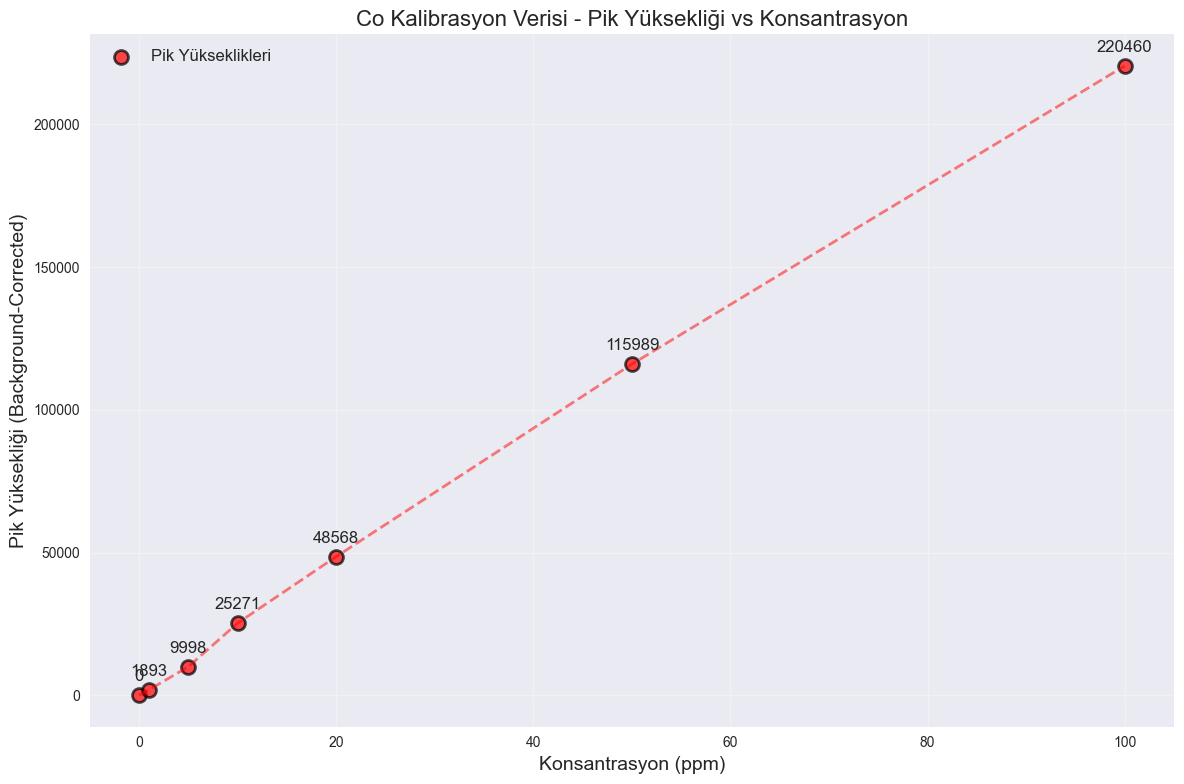

Korelasyon katsayısı: 0.9995
Kolerasyon katsayısı MTA için raporda da belirtildiği gibi 0.999** değerini sağlıyor.


In [16]:
# Maksimum pik yüksekliklerini hesaplama

def calculate_peak_height(corrected_data, method='max'):
    if method == 'max':
        return corrected_data['Corrected_Spectrum'].max()
    elif method == 'peak_area':
        # Pik alanını hesapla (trapezoid rule)
        return np.trapezoid(corrected_data['Corrected_Spectrum'], 
                       corrected_data['Wavelength'])

print("Pik yüksekliklerini hesaplıyor...")
print("=" * 60)

# Her konsantrasyon için pik yüksekliği hesaplama
peak_heights = []
peak_wavelengths = []

for conc in conc_sorted:
    corrected_data = co_data_corrected[conc]
    
    # Maksimum pik yüksekliği
    max_height = calculate_peak_height(corrected_data, method='max')
    peak_heights.append(max_height)
    
    # Maksimum pikin dalga boyu
    max_idx = corrected_data['Corrected_Spectrum'].idxmax()
    max_wavelength = corrected_data.loc[max_idx, 'Wavelength']
    peak_wavelengths.append(max_wavelength)
    
    print(f"{conc:3.0f} ppm: Pik yüksekliği = {max_height:10.1f}, Dalga boyu = {max_wavelength:.3f} nm")

# Sonuçları DataFrame olarak organize etme
results_df = pd.DataFrame({
    'Konsantrasyon_ppm': conc_sorted,
    'Pik_Yuksekligi': peak_heights,
    'Pik_Dalga_Boyu': peak_wavelengths
})

print(f"\nPik yüksekliği hesaplamaları tamamlandı")
print(f"Konsantrasyon aralığı: {min(conc_sorted):.0f} - {max(conc_sorted):.0f} ppm")
print(f"Pik yüksekliği aralığı: {min(peak_heights):.1f} - {max(peak_heights):.1f}")

# Detaylı sonuçlar tablosu
print("\nDetaylı Sonuçlar:")
print(results_df.to_string(index=False, float_format='%.1f'))

# Pik yüksekliği vs konsantrasyon ilişkisini görselleştirme
plt.figure(figsize=(12, 8))

plt.scatter(conc_sorted, peak_heights, color='red', s=100, alpha=0.7, 
           edgecolors='black', linewidth=2, label='Pik Yükseklikleri')
plt.plot(conc_sorted, peak_heights, color='red', alpha=0.5, linestyle='--', linewidth=2)

# Her noktayı etiketle
for i, (conc, height) in enumerate(zip(conc_sorted, peak_heights)):
    plt.annotate(f'{height:.0f}', (conc, height), 
                textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel('Konsantrasyon (ppm)', fontsize=14)
plt.ylabel('Pik Yüksekliği (Background-Corrected)', fontsize=14)
plt.title('Co Kalibrasyon Verisi - Pik Yüksekliği vs Konsantrasyon', fontsize=16)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Doğrusallık kontrolü - ilk değerlendirme
correlation = np.corrcoef(conc_sorted, peak_heights)[0, 1]

print(f"Korelasyon katsayısı: {correlation:.4f}")

print("Kolerasyon katsayısı MTA için raporda da belirtildiği gibi 0.999** değerini sağlıyor.")


In [17]:
# TensorFlow ile kalibrasyon modeli oluşturma

# Veri hazırlama
print("TensorFlow modeli için veri hazırlığı...")

np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Numpy array'lere dönüştürme
X = np.array(conc_sorted, dtype=np.float32).reshape(-1, 1)  # Konsantrasyonlar
y = np.array(peak_heights, dtype=np.float32)                # Pik yükseklikleri

print(f"Giriş verisi (X) şekli: {X.shape}")
print(f"Çıkış verisi (y) şekli: {y.shape}")
print(f"X verisi: {X.flatten()}")
print(f"y verisi: {y}")

# Veri normalizasyonu
X_mean, X_std = X.mean(), X.std()
y_mean, y_std = y.mean(), y.std()

X_normalized = (X - X_mean) / X_std
y_normalized = (y - y_mean) / y_std

print(f"X normalizasyon: mean={X_mean:.2f}, std={X_std:.2f}")
print(f"y normalizasyon: mean={y_mean:.2f}, std={y_std:.2f}")


## Model oluşturma


# Model 1: Lineer Regresyon
print("\nModel 1: Lineer Regresyon")
model_linear = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=(1,), activation='linear', name='linear_layer')
])

model_linear.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),  # Daha düşük learning rate
    loss='mse',
    metrics=['mae']
)

print("Model mimarisi:")
model_linear.summary()




# Model 2: Polinom Regresyon
print("\nModel 2: Polinom Regresyon")
model_poly = tf.keras.Sequential([
    tf.keras.layers.Dense(4, input_shape=(1,), activation='relu', name='hidden_1'),
    tf.keras.layers.Dense(2, activation='relu', name='hidden_2'),
    tf.keras.layers.Dense(1, activation='linear', name='output')
])

model_poly.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),  # Daha düşük learning rate
    loss='mse',
    metrics=['mae']
) 





print("Model mimarisi:")
model_poly.summary()


TensorFlow modeli için veri hazırlığı...
Giriş verisi (X) şekli: (7, 1)
Çıkış verisi (y) şekli: (7,)
X verisi: [  0.   1.   5.  10.  20.  50. 100.]
y verisi: [     0.      1893.214   9997.539  25270.941  48568.027 115989.18
 220460.5  ]
X normalizasyon: mean=26.57, std=33.98
y normalizasyon: mean=60311.34, std=75304.26

Model 1: Lineer Regresyon
Model mimarisi:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ linear_layer (Dense)            │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (8.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 0 (0.00 B)


Model 2: Polinom Regresyon
Model mimarisi:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_1 (Dense)                │ (None, 4)              │             8 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_2 (Dense)                │ (None, 2)              │            10 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21 (84.00 B)

 Trainable params: 21 (84.00 B)

 Non-trainable params: 0 (0.00 B)

Modeller eğitiliyor...

Lineer model eğitimi başlıyor...
Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - loss: 0.0593 - mae: 0.1916
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0569 - mae: 0.1876
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0546 - mae: 0.1819
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0523 - mae: 0.1792
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0501 - mae: 0.1763
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0479 - mae: 0.1725
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0458 - mae: 0.1680
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0437 - mae: 0.1632
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0417 - mae: 0.1585
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0398 - mae: 0.1542
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0378 - mae: 0.1504
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0360 - mae: 0.1468
Epo

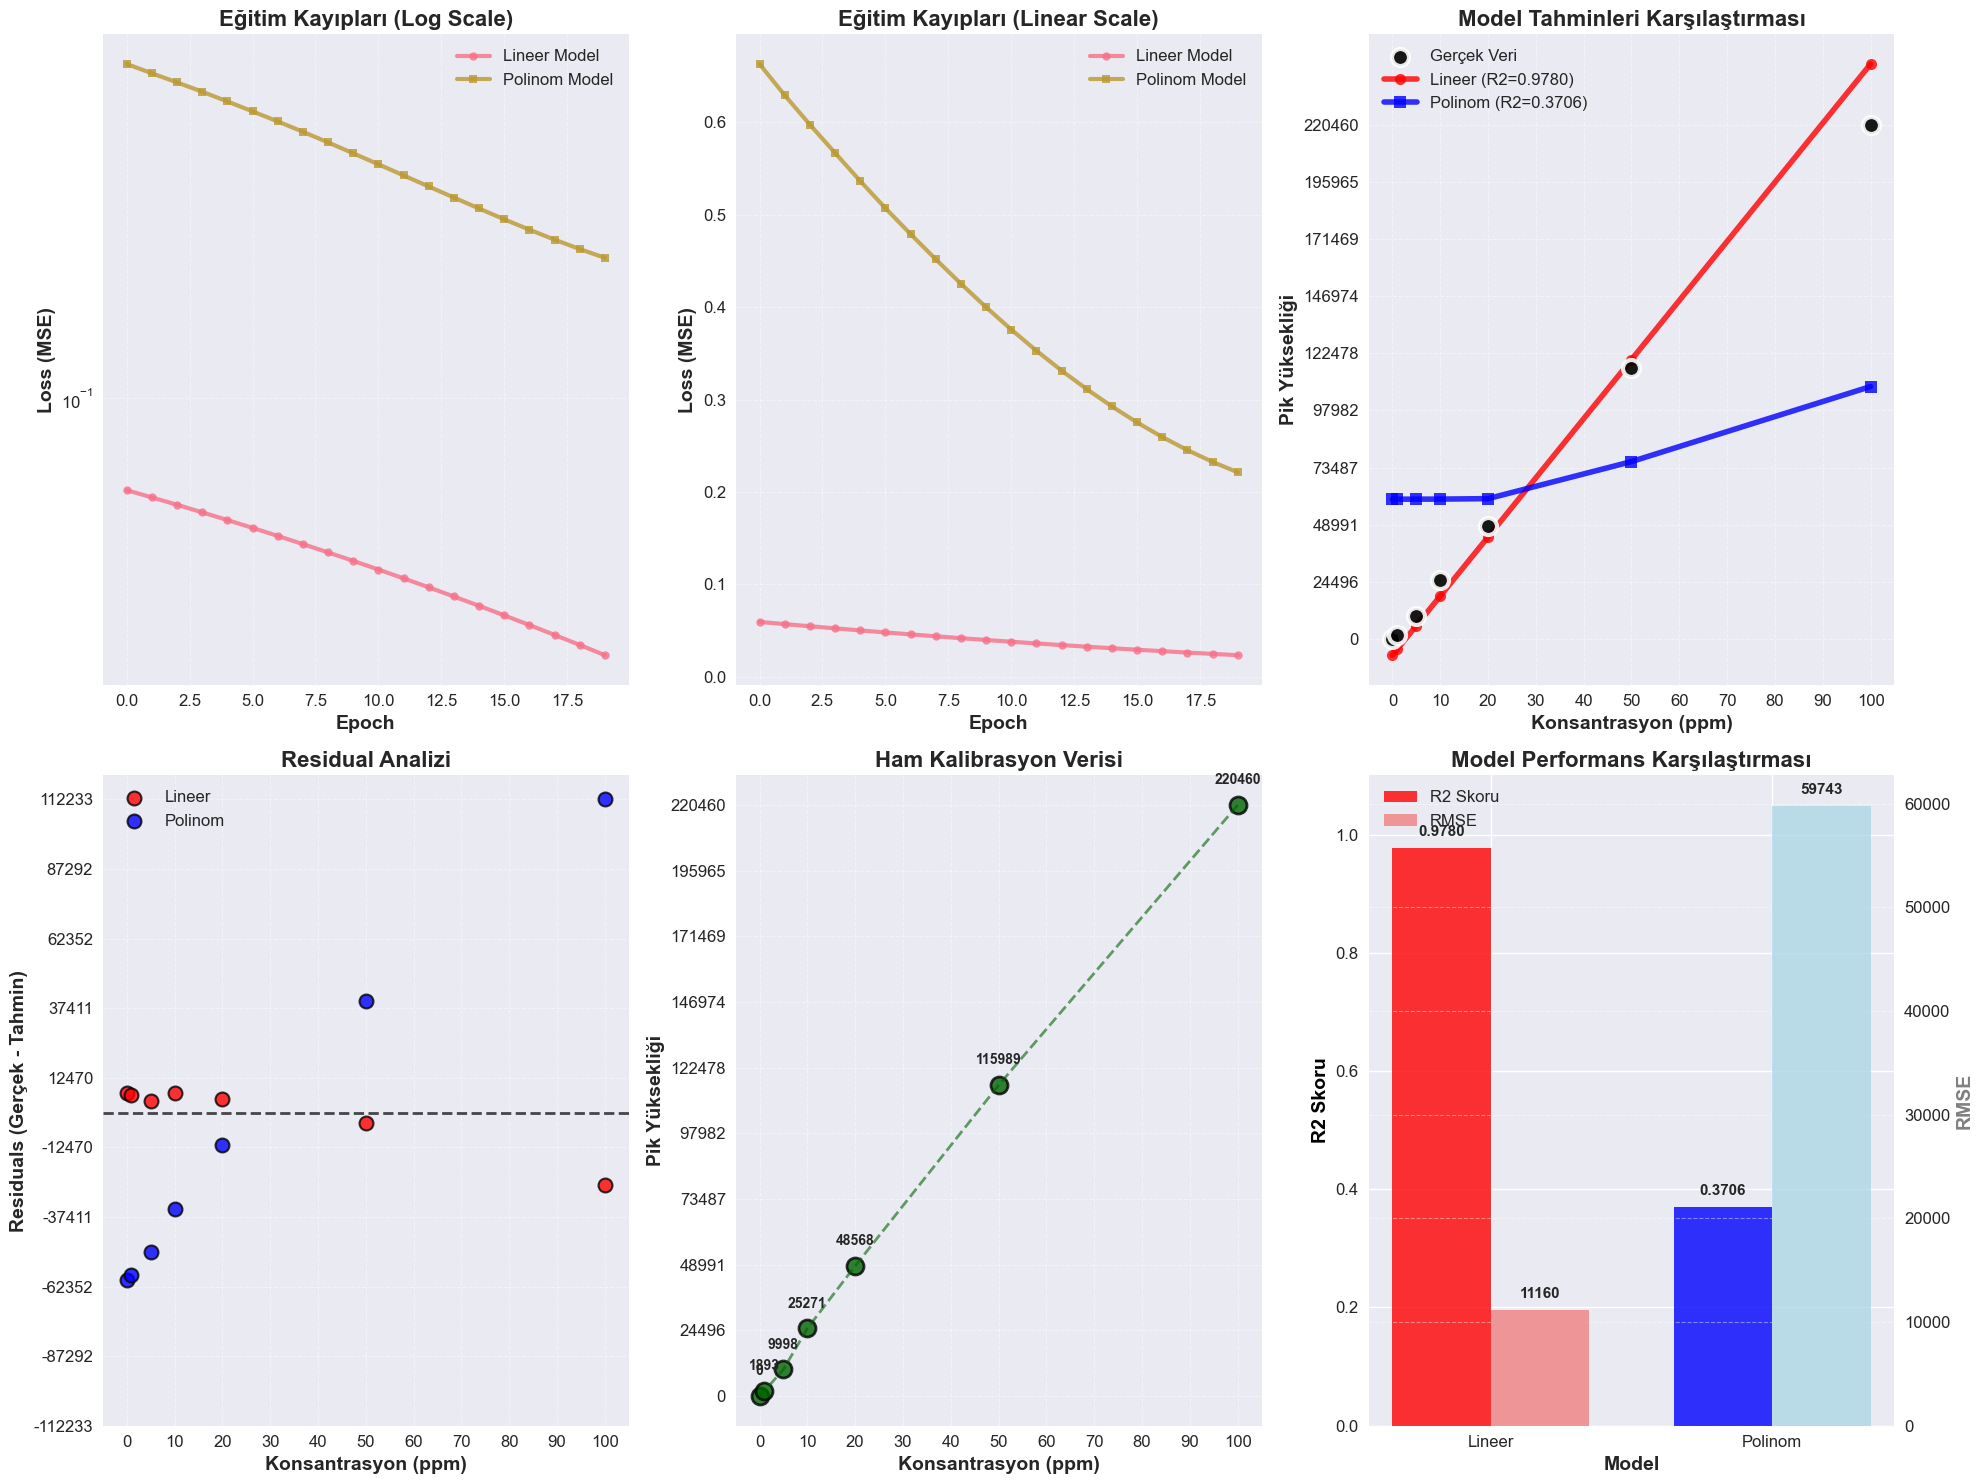

In [18]:
# Model eğitimi
print("Modeller eğitiliyor...")

# Callback fonksiyonları - eğitimi izlemek için (daha agresif early stopping)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='loss', patience=20, restore_best_weights=True, verbose=1
)

##

# Lineer modeli eğitme
print("\nLineer model eğitimi başlıyor...")
history_linear = model_linear.fit(
    X_normalized, y_normalized,
    epochs=20,  # 30=>20
    batch_size=len(X_normalized),
    verbose=1,
    callbacks=[early_stopping]
)

print(f"Lineer model eğitimi tamamlandı - {len(history_linear.history['loss'])} epoch")

##

# Polinom modeli eğitme
print("\nPolinom model eğitimi başlıyor...")
history_poly = model_poly.fit(
    X_normalized, y_normalized,
    epochs=20,
    batch_size=len(X_normalized),
    verbose=1,
    callbacks=[early_stopping]
)

print(f"Polinom model eğitimi tamamlandı - {len(history_poly.history['loss'])} epoch")

# Model tahminleri
print("\nModel tahminleri hesaplanıyor...")
y_pred_linear_norm = model_linear.predict(X_normalized, verbose=0)
y_pred_poly_norm = model_poly.predict(X_normalized, verbose=0)

# Denormalizasyon - orijinal ölçeğe geri dönüştürme
y_pred_linear = y_pred_linear_norm * y_std + y_mean
y_pred_poly = y_pred_poly_norm * y_std + y_mean

# Model performanslarını değerlendirme
r2_linear = r2_score(y, y_pred_linear)
r2_poly = r2_score(y, y_pred_poly)
mse_linear = mean_squared_error(y, y_pred_linear)
mse_poly = mean_squared_error(y, y_pred_poly)

print("\nModel Performans Karşılaştırması:")
print("=" * 50)
print(f"Lineer Model:")
print(f"  R2 Skoru: {r2_linear:.6f}")
print(f"  MSE: {mse_linear:.2f}")
print(f"  RMSE: {np.sqrt(mse_linear):.2f}")

print(f"\nPolinom Model:")
print(f"  R2 Skoru: {r2_poly:.6f}")
print(f"  MSE: {mse_poly:.2f}")
print(f"  RMSE: {np.sqrt(mse_poly):.2f}")

# En iyi modeli belirleme
if r2_poly > r2_linear:
    best_model = "Polinom"
    best_r2 = r2_poly
    best_mse = mse_poly
else:
    best_model = "Lineer"
    best_r2 = r2_linear
    best_mse = mse_linear

print(f"\nEn İyi Model: {best_model}")
print(f"En Yüksek R2 Skoru: {best_r2:.6f}")
print(f"En Düşük MSE: {best_mse:.2f}")

# Eğitim sürecini görselleştirme
plt.figure(figsize=(20, 15))

# Eğitim kayıpları
plt.subplot(2, 3, 1)
plt.plot(history_linear.history['loss'], label='Lineer Model', linewidth=3, marker='o', markersize=6, alpha=0.8)
plt.plot(history_poly.history['loss'], label='Polinom Model', linewidth=3, marker='s', markersize=6, alpha=0.8)
plt.title('Eğitim Kayıpları (Log Scale)', fontsize=16, fontweight='bold')
plt.xlabel('Epoch', fontsize=14, fontweight='bold')
plt.ylabel('Loss (MSE)', fontsize=14, fontweight='bold')
plt.legend(fontsize=12)
plt.yscale('log')
plt.grid(True, alpha=0.4, linestyle='--', linewidth=0.8)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Eğitim kayıpları - Lineer scale
plt.subplot(2, 3, 2)
plt.plot(history_linear.history['loss'], label='Lineer Model', linewidth=3, marker='o', markersize=6, alpha=0.8)
plt.plot(history_poly.history['loss'], label='Polinom Model', linewidth=3, marker='s', markersize=6, alpha=0.8)
plt.title('Eğitim Kayıpları (Linear Scale)', fontsize=16, fontweight='bold')
plt.xlabel('Epoch', fontsize=14, fontweight='bold')
plt.ylabel('Loss (MSE)', fontsize=14, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.4, linestyle='--', linewidth=0.8)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Model tahminleri karşılaştırması - Detaylı
plt.subplot(2, 3, 3)
plt.scatter(conc_sorted, peak_heights, color='black', s=150, label='Gerçek Veri', 
           zorder=5, edgecolors='white', linewidth=3, alpha=0.9)
plt.plot(conc_sorted, y_pred_linear.flatten(), 'r-', label=f'Lineer (R2={r2_linear:.4f})', 
         linewidth=4, alpha=0.8, marker='o', markersize=8)
plt.plot(conc_sorted, y_pred_poly.flatten(), 'b-', label=f'Polinom (R2={r2_poly:.4f})', 
         linewidth=4, alpha=0.8, marker='s', markersize=8)

# Detaylı eksen ayarları
plt.xlabel('Konsantrasyon (ppm)', fontsize=14, fontweight='bold')
plt.ylabel('Pik Yüksekliği', fontsize=14, fontweight='bold')
plt.title('Model Tahminleri Karşılaştırması', fontsize=16, fontweight='bold')

# X ekseni detayları
x_ticks_conc = np.arange(0, max(conc_sorted) + 10, 10)
plt.xticks(x_ticks_conc, fontsize=12)

# Y ekseni detayları
y_ticks_peak = np.linspace(0, max(peak_heights), 10)
plt.yticks(y_ticks_peak, fontsize=12)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0f}'))

plt.legend(fontsize=12)
plt.grid(True, alpha=0.4, linestyle='--', linewidth=0.8)

# Residual analizi - Detaylı
plt.subplot(2, 3, 4)
residuals_linear = y - y_pred_linear.flatten()
residuals_poly = y - y_pred_poly.flatten()
plt.scatter(conc_sorted, residuals_linear, color='red', alpha=0.8, label='Lineer', 
           s=100, edgecolors='black', linewidth=1.5)
plt.scatter(conc_sorted, residuals_poly, color='blue', alpha=0.8, label='Polinom', 
           s=100, edgecolors='black', linewidth=1.5)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.7, linewidth=2)

plt.xlabel('Konsantrasyon (ppm)', fontsize=14, fontweight='bold')
plt.ylabel('Residuals (Gerçek - Tahmin)', fontsize=14, fontweight='bold')
plt.title('Residual Analizi', fontsize=16, fontweight='bold')

# Residual için detaylı eksen
plt.xticks(x_ticks_conc, fontsize=12)
residual_range = max(max(abs(residuals_linear)), max(abs(residuals_poly)))
y_ticks_res = np.linspace(-residual_range, residual_range, 10)
plt.yticks(y_ticks_res, fontsize=12)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0f}'))

plt.legend(fontsize=12)
plt.grid(True, alpha=0.4, linestyle='--', linewidth=0.8)

# Pik yüksekliği vs konsantrasyon - Ham veri detayı
plt.subplot(2, 3, 5)
plt.scatter(conc_sorted, peak_heights, color='darkgreen', s=150, alpha=0.8, 
           edgecolors='black', linewidth=2)
plt.plot(conc_sorted, peak_heights, color='darkgreen', alpha=0.6, linewidth=2, linestyle='--')

# Her noktayı etiketle
for i, (conc, height) in enumerate(zip(conc_sorted, peak_heights)):
    plt.annotate(f'{height:.0f}', (conc, height), 
                textcoords="offset points", xytext=(0,15), ha='center', 
                fontsize=10, fontweight='bold')

plt.xlabel('Konsantrasyon (ppm)', fontsize=14, fontweight='bold')
plt.ylabel('Pik Yüksekliği', fontsize=14, fontweight='bold')
plt.title('Ham Kalibrasyon Verisi', fontsize=16, fontweight='bold')

# Detaylı eksen ayarları
plt.xticks(x_ticks_conc, fontsize=12)
plt.yticks(y_ticks_peak, fontsize=12)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0f}'))

plt.grid(True, alpha=0.4, linestyle='--', linewidth=0.8)

# Model performans karşılaştırması - Bar chart
plt.subplot(2, 3, 6)
models = ['Lineer', 'Polinom']
r2_scores = [r2_linear, r2_poly]
rmse_scores = [np.sqrt(mse_linear), np.sqrt(mse_poly)]

x_pos = np.arange(len(models))
width = 0.35

# R2 skorları
ax1 = plt.gca()
bars1 = ax1.bar(x_pos - width/2, r2_scores, width, label='R2 Skoru', 
                alpha=0.8, color=['red', 'blue'])
ax1.set_xlabel('Model', fontsize=14, fontweight='bold')
ax1.set_ylabel('R2 Skoru', fontsize=14, fontweight='bold', color='black')
ax1.set_title('Model Performans Karşılaştırması', fontsize=16, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(models, fontsize=12)
ax1.tick_params(axis='y', labelsize=12)
ax1.set_ylim(0, 1.1)

# RMSE skorları (ikinci y ekseni)
ax2 = ax1.twinx()
bars2 = ax2.bar(x_pos + width/2, rmse_scores, width, label='RMSE', 
                alpha=0.8, color=['lightcoral', 'lightblue'])
ax2.set_ylabel('RMSE', fontsize=14, fontweight='bold', color='gray')
ax2.tick_params(axis='y', labelsize=12)

# Değerleri bar üzerine yaz
for i, (r2, rmse) in enumerate(zip(r2_scores, rmse_scores)):
    ax1.text(i - width/2, r2 + 0.02, f'{r2:.4f}', ha='center', fontsize=11, fontweight='bold')
    ax2.text(i + width/2, rmse + max(rmse_scores)*0.02, f'{rmse:.0f}', ha='center', fontsize=11, fontweight='bold')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=12)

plt.grid(True, alpha=0.4, linestyle='--', linewidth=0.8)

plt.tight_layout()
plt.show()


Adım 7: Kalibrasyon Grafiği ve Değerlendirme

Bu aşamada konsantrasyon ve sinyal şiddeti arasındaki ilişki görselleştirildi
Kalibrasyon eğrisinin metrikleri incelendi


Detaylı Sonuçlar
 Konsantrasyon (ppm)  Gerçek Pik Yüksekliği  Lineer Model Tahmini  Polinom Model Tahmini   Lineer Hata  Polinom Hata  Lineer Hata (%)  Polinom Hata (%)
                 0.0                   0.00          -6961.899902           59934.828125   6961.899902 -59934.828125              inf              -inf
                 1.0                1893.21          -4426.930176           59934.828125   6320.140137 -58041.621094           333.83          -3065.77
                 5.0                9997.54           5712.959961           59934.828125   4284.569824 -49937.300781            42.86           -499.50
                10.0               25270.94          18387.820312           59967.070312   6883.120117 -34696.128906            27.24           -137.30
                20.0               48568.03          43737.539062           60158.281250   4830.490234 -11590.250000             9.95            -23.86
                50.0              115989.18         119786.671875      

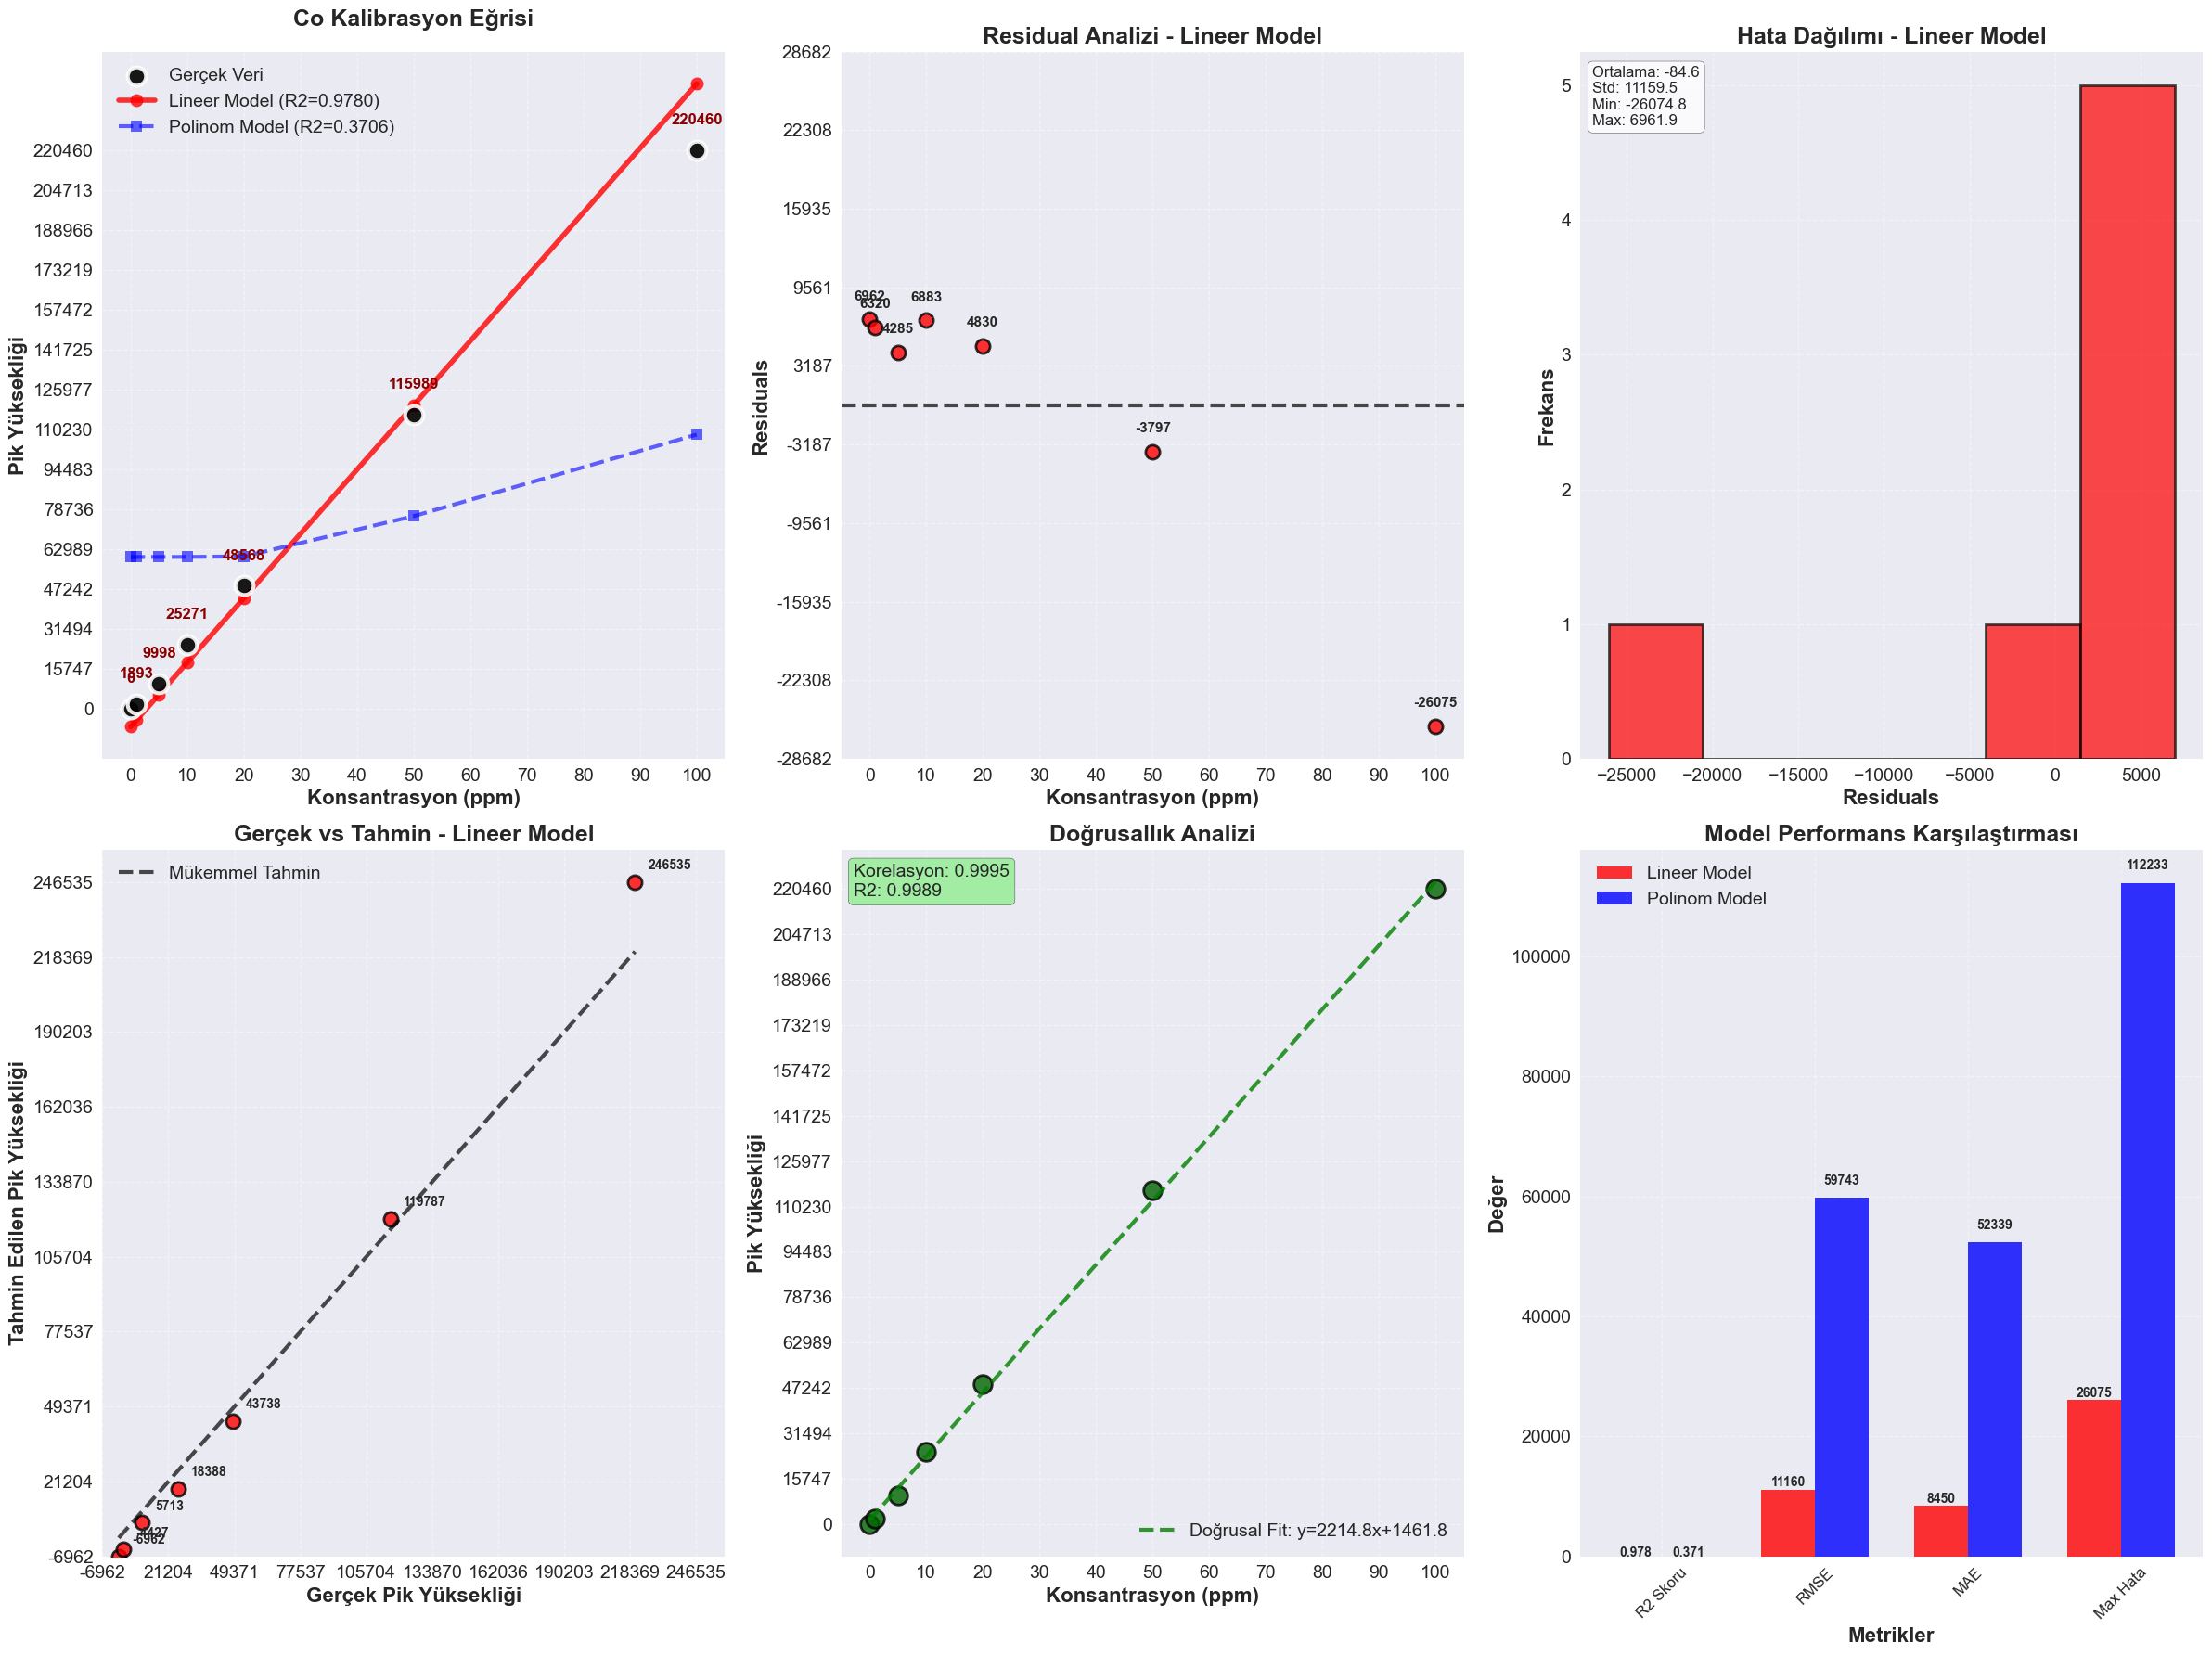


Ortalama Mutlak Hata: 8450.36
Relatif Hata: 14.01%


In [19]:
# Detaylı sonuç tablosu ve final değerlendirme
print("Detaylı Sonuçlar")
print("=" * 60)

# Detaylı sonuç tablosu oluşturma
detailed_results = pd.DataFrame({
    'Konsantrasyon (ppm)': conc_sorted,
    'Gerçek Pik Yüksekliği': peak_heights,
    'Lineer Model Tahmini': y_pred_linear.flatten(),
    'Polinom Model Tahmini': y_pred_poly.flatten(),
    'Lineer Hata': residuals_linear,
    'Polinom Hata': residuals_poly,
    'Lineer Hata (%)': (residuals_linear / np.array(peak_heights)) * 100,
    'Polinom Hata (%)': (residuals_poly / np.array(peak_heights)) * 100
})

print(detailed_results.round(2).to_string(index=False))

# Özet istatistikler
print(f"\n{'='*60}")
print("Özet İstatistikler")
print("=" * 60)
print(f"Analiz Edilen Element: Co (Kobalt)")
print(f"Dalga Boyu: {wavelength_nm} nm")
print(f"Konsantrasyon Aralığı: {min(conc_sorted):.0f} - {max(conc_sorted):.0f} ppm")
print(f"Veri Noktası Sayısı: {len(conc_sorted)}")
print(f"Pik Yüksekliği Aralığı: {min(peak_heights):.0f} - {max(peak_heights):.0f}")

print(f"\n ML Modellerinin Performansları:")
print(f"   Lineer Model  -> R2: {r2_linear:.6f}, RMSE: {np.sqrt(mse_linear):.1f}")
print(f"   Polinom Model -> R2: {r2_poly:.6f}, RMSE: {np.sqrt(mse_poly):.1f}")

print(f"\nEn İyi Model: {best_model}")
print(f"En Yüksek R2 Skoru: {best_r2:.6f}")



if best_model == "Lineer":
    # Normalizasyon parametrelerini kullanarak orijinal katsayıları hesaplama
    weight = model_linear.layers[0].get_weights()[0][0][0]
    bias = model_linear.layers[0].get_weights()[1][0]
    
    # Denormalizasyon
    slope = weight * (y_std / X_std)
    intercept = bias * y_std + y_mean - slope * X_mean
    
    print(f"\nLineer Model Denklemi:")
    print(f"   Pik Yüksekliği = {slope:.2f} × Konsantrasyon + {intercept:.2f}")
    print(f"   y = {slope:.2f}x + {intercept:.2f}")



# Kalibrasyon eğrisinin final görselleştirmesi
plt.figure(figsize=(24, 18))

# Ana kalibrasyon grafiği - Detaylı
plt.subplot(2, 3, 1)
plt.scatter(conc_sorted, peak_heights, color='black', s=200, label='Gerçek Veri', 
           zorder=5, edgecolors='white', linewidth=3, alpha=0.9)

# En iyi modeli vurgula
if best_model == "Lineer":
    plt.plot(conc_sorted, y_pred_linear.flatten(), 'r-', linewidth=4, 
             label=f'Lineer Model (R2={r2_linear:.4f})', alpha=0.8, marker='o', markersize=10)
    plt.plot(conc_sorted, y_pred_poly.flatten(), 'b--', linewidth=3, 
             label=f'Polinom Model (R2={r2_poly:.4f})', alpha=0.6, marker='s', markersize=8)
else:
    plt.plot(conc_sorted, y_pred_poly.flatten(), 'b-', linewidth=4, 
             label=f'Polinom Model (R2={r2_poly:.4f})', alpha=0.8, marker='s', markersize=10)
    plt.plot(conc_sorted, y_pred_linear.flatten(), 'r--', linewidth=3, 
             label=f'Lineer Model (R2={r2_linear:.4f})', alpha=0.6, marker='o', markersize=8)

# Detaylı eksen ayarları
plt.xlabel('Konsantrasyon (ppm)', fontsize=16, fontweight='bold')
plt.ylabel('Pik Yüksekliği', fontsize=16, fontweight='bold')
plt.title('Co Kalibrasyon Eğrisi', fontsize=18, fontweight='bold', pad=20)

# X ekseni: her 10 ppm'de bir tick
x_ticks_main = np.arange(0, max(conc_sorted) + 10, 10)
plt.xticks(x_ticks_main, fontsize=14)

# Y ekseni: 15 tick
y_ticks_main = np.linspace(0, max(peak_heights), 15)
plt.yticks(y_ticks_main, fontsize=14)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0f}'))

# Her veri noktasını etiketle
for i, (conc, height) in enumerate(zip(conc_sorted, peak_heights)):
    plt.annotate(f'{height:.0f}', (conc, height), 
                textcoords="offset points", xytext=(0,20), ha='center', 
                fontsize=12, fontweight='bold', color='darkred')

plt.legend(fontsize=14, loc='upper left')
plt.grid(True, alpha=0.4, linestyle='--', linewidth=1)




# Residual analizi
plt.subplot(2, 3, 2)
if best_model == "Lineer":
    plt.scatter(conc_sorted, residuals_linear, color='red', alpha=0.8, s=120, 
               edgecolors='black', linewidth=2)
    plt.title('Residual Analizi - Lineer Model', fontsize=18, fontweight='bold')
    mean_abs_error = np.mean(np.abs(residuals_linear))
    residuals_to_plot = residuals_linear
else:
    plt.scatter(conc_sorted, residuals_poly, color='blue', alpha=0.8, s=120,
               edgecolors='black', linewidth=2)
    plt.title('Residual Analizi - Polinom Model', fontsize=18, fontweight='bold')
    mean_abs_error = np.mean(np.abs(residuals_poly))
    residuals_to_plot = residuals_poly

plt.axhline(y=0, color='black', linestyle='--', alpha=0.7, linewidth=3)
plt.xlabel('Konsantrasyon (ppm)', fontsize=16, fontweight='bold')
plt.ylabel('Residuals', fontsize=16, fontweight='bold')

# Residual değerlerini etiketle
for i, (conc, res) in enumerate(zip(conc_sorted, residuals_to_plot)):
    plt.annotate(f'{res:.0f}', (conc, res), 
                textcoords="offset points", xytext=(0,15), ha='center', 
                fontsize=11, fontweight='bold')

plt.xticks(x_ticks_main, fontsize=14)
residual_range = max(abs(residuals_to_plot))
y_ticks_res = np.linspace(-residual_range*1.1, residual_range*1.1, 10)
plt.yticks(y_ticks_res, fontsize=14)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0f}'))

plt.grid(True, alpha=0.4, linestyle='--', linewidth=1)





# Hata dağılımı
plt.subplot(2, 3, 3)
if best_model == "Lineer":
    plt.hist(residuals_linear, bins=6, alpha=0.7, color='red', edgecolor='black', linewidth=2)
    plt.title('Hata Dağılımı - Lineer Model', fontsize=18, fontweight='bold')
    residuals_hist = residuals_linear
else:
    plt.hist(residuals_poly, bins=6, alpha=0.7, color='blue', edgecolor='black', linewidth=2)
    plt.title('Hata Dağılımı - Polinom Model', fontsize=18, fontweight='bold')
    residuals_hist = residuals_poly

plt.xlabel('Residuals', fontsize=16, fontweight='bold')
plt.ylabel('Frekans', fontsize=16, fontweight='bold')

# İstatistikler ekle
plt.text(0.02, 0.98, f'Ortalama: {np.mean(residuals_hist):.1f}\nStd: {np.std(residuals_hist):.1f}\nMin: {np.min(residuals_hist):.1f}\nMax: {np.max(residuals_hist):.1f}', 
         transform=plt.gca().transAxes, fontsize=12, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True, alpha=0.4, linestyle='--', linewidth=1)






# Gerçek vs Tahmin grafiği
plt.subplot(2, 3, 4)
if best_model == "Lineer":
    plt.scatter(peak_heights, y_pred_linear.flatten(), color='red', alpha=0.8, s=120,
               edgecolors='black', linewidth=2)
    plt.title('Gerçek vs Tahmin - Lineer Model', fontsize=18, fontweight='bold')
    y_pred_plot = y_pred_linear.flatten()
else:
    plt.scatter(peak_heights, y_pred_poly.flatten(), color='blue', alpha=0.8, s=120,
               edgecolors='black', linewidth=2)
    plt.title('Gerçek vs Tahmin - Polinom Model', fontsize=18, fontweight='bold')
    y_pred_plot = y_pred_poly.flatten()

# Mükemmel tahmin çizgisi
plt.plot([min(peak_heights), max(peak_heights)], [min(peak_heights), max(peak_heights)], 
         'k--', alpha=0.7, linewidth=3, label='Mükemmel Tahmin')

plt.xlabel('Gerçek Pik Yüksekliği', fontsize=16, fontweight='bold')
plt.ylabel('Tahmin Edilen Pik Yüksekliği', fontsize=16, fontweight='bold')

# Tahmin değerlerini etiketle
for i, (real, pred) in enumerate(zip(peak_heights, y_pred_plot)):
    plt.annotate(f'{pred:.0f}', (real, pred), 
                textcoords="offset points", xytext=(10,10), ha='left', 
                fontsize=10, fontweight='bold')

# Detaylı eksen ayarları
min_val = min(min(peak_heights), min(y_pred_plot))
max_val = max(max(peak_heights), max(y_pred_plot))
plt.xlim(min_val*0.95, max_val*1.05)
plt.ylim(min_val*0.95, max_val*1.05)

x_ticks_pred = np.linspace(min_val, max_val, 10)
plt.xticks(x_ticks_pred, fontsize=14)
plt.yticks(x_ticks_pred, fontsize=14)
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0f}'))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0f}'))

plt.legend(fontsize=14)
plt.grid(True, alpha=0.4, linestyle='--', linewidth=1)








# Konsantrasyon vs Pik Yüksekliği - Doğrusallık analizi
plt.subplot(2, 3, 5)
plt.scatter(conc_sorted, peak_heights, color='darkgreen', s=200, alpha=0.8, 
           edgecolors='black', linewidth=2)

# Doğrusal fit çizgisi
z = np.polyfit(conc_sorted, peak_heights, 1)
p = np.poly1d(z)
plt.plot(conc_sorted, p(conc_sorted), 'g--', linewidth=3, alpha=0.8, label=f'Doğrusal Fit: y={z[0]:.1f}x+{z[1]:.1f}')

plt.xlabel('Konsantrasyon (ppm)', fontsize=16, fontweight='bold')
plt.ylabel('Pik Yüksekliği', fontsize=16, fontweight='bold')
plt.title('Doğrusallık Analizi', fontsize=18, fontweight='bold')

# Korelasyon katsayısı
correlation = np.corrcoef(conc_sorted, peak_heights)[0, 1]
plt.text(0.02, 0.98, f'Korelasyon: {correlation:.4f}\nR2: {correlation**2:.4f}', 
         transform=plt.gca().transAxes, fontsize=14, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))

plt.xticks(x_ticks_main, fontsize=14)
plt.yticks(y_ticks_main, fontsize=14)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0f}'))

plt.legend(fontsize=14)
plt.grid(True, alpha=0.4, linestyle='--', linewidth=1)










# Model karşılaştırma özeti
plt.subplot(2, 3, 6)
metrics = ['R2 Skoru', 'RMSE', 'MAE', 'Max Hata']
linear_metrics = [r2_linear, np.sqrt(mse_linear), np.mean(np.abs(residuals_linear)), np.max(np.abs(residuals_linear))]
poly_metrics = [r2_poly, np.sqrt(mse_poly), np.mean(np.abs(residuals_poly)), np.max(np.abs(residuals_poly))]

x_pos = np.arange(len(metrics))
width = 0.35

plt.bar(x_pos - width/2, linear_metrics, width, label='Lineer Model', alpha=0.8, color='red')
plt.bar(x_pos + width/2, poly_metrics, width, label='Polinom Model', alpha=0.8, color='blue')

plt.xlabel('Metrikler', fontsize=16, fontweight='bold')
plt.ylabel('Değer', fontsize=16, fontweight='bold')
plt.title('Model Performans Karşılaştırması', fontsize=18, fontweight='bold')
plt.xticks(x_pos, metrics, fontsize=12, rotation=45)
plt.yticks(fontsize=14)

# Değerleri bar üzerine yaz
for i, (lin, pol) in enumerate(zip(linear_metrics, poly_metrics)):
    if i == 0:  # R2 için
        plt.text(i - width/2, lin + 0.02, f'{lin:.3f}', ha='center', fontsize=10, fontweight='bold')
        plt.text(i + width/2, pol + 0.02, f'{pol:.3f}', ha='center', fontsize=10, fontweight='bold')
    else:  # Diğer metrikler için
        plt.text(i - width/2, lin + max(linear_metrics)*0.02, f'{lin:.0f}', ha='center', fontsize=10, fontweight='bold')
        plt.text(i + width/2, pol + max(poly_metrics)*0.02, f'{pol:.0f}', ha='center', fontsize=10, fontweight='bold')

plt.legend(fontsize=14)
plt.grid(True, alpha=0.4, linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()

print(f"\nOrtalama Mutlak Hata: {mean_abs_error:.2f}")
print(f"Relatif Hata: {(mean_abs_error / np.mean(peak_heights)) * 100:.2f}%")


In [24]:
# Final değerlendirme ve öneriler
print("Final Değerlendirme")
print("=" * 60)

# Tahmin fonksiyonu oluşturma
def predict_concentration_co(peak_height, use_best_model=True):

    # En iyi modeli seç
    if use_best_model:
        if best_model == "Lineer":
            model = model_linear
        else:
            model = model_poly
    else:
        model = model_linear
    
    # Ters tahmin için iteratif yöntem
    concentrations_test = np.linspace(0, 120, 1000)
    X_test = (concentrations_test.reshape(-1, 1) - X_mean) / X_std
    y_pred_test = model.predict(X_test, verbose=0) * y_std + y_mean
    
    # En yakın değeri bulma
    idx = np.argmin(np.abs(y_pred_test.flatten() - peak_height))
    predicted_conc = concentrations_test[idx]
    
    return predicted_conc

print(f"En iyi model: {best_model} (R² = {best_r2:.6f})")

# Özetin özeti
print(f"\nSon Özet:")
print("=" * 70)
print(f"- Element: Co (Kobalt)")
print(f"- Dalga boyu: {wavelength_nm} nm")
print(f"- Konsantrasyon aralığı: {min(conc_sorted):.0f}-{max(conc_sorted):.0f} ppm")
print(f"- Veri noktası sayısı: {len(conc_sorted)}")
print(f"- En iyi model: {best_model}")
print(f"- R² skoru: {best_r2:.6f}")
print(f"- Ortalama hata: {mean_abs_error:.1f}")
print(f"- Relatif hata: {(mean_abs_error / np.mean(peak_heights)) * 100:.2f}%")


Final Değerlendirme
En iyi model: Lineer (R² = 0.978038)

Son Özet:
- Element: Co (Kobalt)
- Dalga boyu: 228.615 nm
- Konsantrasyon aralığı: 0-100 ppm
- Veri noktası sayısı: 7
- En iyi model: Lineer
- R² skoru: 0.978038
- Ortalama hata: 8450.4
- Relatif hata: 14.01%
